In [25]:
!nvidia-smi


Mon Feb  9 00:42:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [35]:
%%writefile blur_shared.cu
#include <cuda_runtime.h>
#include <iostream>
#include <vector>
#include <random>
#include <algorithm>
#include <cstdint>
#include <cstdlib>
#include <cmath>
#include <fstream>
#include <fstream>
#include <iomanip>


static void save_pgm(const char* path, const std::vector<uint8_t>& img, int W, int H) {
  std::ofstream f(path, std::ios::binary);
  f << "P5\n" << W << " " << H << "\n255\n";
  f.write(reinterpret_cast<const char*>(img.data()), (std::streamsize)img.size());
}


#define CHECK_CUDA(x) do { \
  cudaError_t e = (x); \
  if (e != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(e) \
              << " at " << __FILE__ << ":" << __LINE__ << "\n"; \
    std::exit(1); \
  } \
} while(0)

static int max_abs_diff(const std::vector<uint8_t>& a, const std::vector<uint8_t>& b) {
  int md = 0;
  for (size_t i = 0; i < a.size(); i++) {
    int d = std::abs((int)a[i] - (int)b[i]);
    md = std::max(md, d);
  }
  return md;
}

// template timing helper (works with lambdas)
template <typename LaunchFn>
static float time_kernel_ms(LaunchFn launch, int iters = 200) {
  cudaEvent_t start, stop;
  CHECK_CUDA(cudaEventCreate(&start));
  CHECK_CUDA(cudaEventCreate(&stop));

  cudaStream_t s;
  CHECK_CUDA(cudaStreamCreate(&s));

  // warmup
  launch(s);
  CHECK_CUDA(cudaGetLastError());
  CHECK_CUDA(cudaStreamSynchronize(s));

  CHECK_CUDA(cudaEventRecord(start, s));
  for (int i = 0; i < iters; i++) launch(s);
  CHECK_CUDA(cudaEventRecord(stop, s));
  CHECK_CUDA(cudaEventSynchronize(stop));

  float ms = 0.0f;
  CHECK_CUDA(cudaEventElapsedTime(&ms, start, stop));

  CHECK_CUDA(cudaStreamDestroy(s));
  CHECK_CUDA(cudaEventDestroy(start));
  CHECK_CUDA(cudaEventDestroy(stop));

  return ms / iters;
}

// ---------------- CPU reference (box blur radius R) ----------------
static void cpu_blur_box(const std::vector<uint8_t>& in,
                         std::vector<uint8_t>& out,
                         int W, int H, int R) {
  for (int y = 0; y < H; y++) {
    for (int x = 0; x < W; x++) {
      int sum = 0, cnt = 0;
      for (int dy = -R; dy <= R; dy++) {
        for (int dx = -R; dx <= R; dx++) {
          int xx = x + dx, yy = y + dy;
          if (xx >= 0 && xx < W && yy >= 0 && yy < H) {
            sum += (int)in[yy * W + xx];
            cnt++;
          }
        }
      }
      out[y * W + x] = (uint8_t)(sum / cnt);
    }
  }
}

// ---------------- GPU naive blur (radius R) ----------------
__global__ void blur_naive_R(const uint8_t* in, uint8_t* out, int W, int H, int R) {
  int x = blockIdx.x * blockDim.x + threadIdx.x;
  int y = blockIdx.y * blockDim.y + threadIdx.y;
  if (x >= W || y >= H) return;

  int sum = 0, cnt = 0;
  for (int dy = -R; dy <= R; dy++) {
    for (int dx = -R; dx <= R; dx++) {
      int xx = x + dx, yy = y + dy;
      if (xx >= 0 && xx < W && yy >= 0 && yy < H) {
        sum += (int)in[yy * W + xx];
        cnt++;
      }
    }
  }
  out[y * W + x] = (uint8_t)(sum / cnt);
}

// ---------------- GPU shared-memory tiled blur (radius R fixed at compile time) ----------------
// Uses dynamic shared memory sized to (TILE+2R)*(TILE+2R)
template<int TILE, int R>
__global__ void blur_shared_tiled_R(const uint8_t* in, uint8_t* out, int W, int H) {
  extern __shared__ uint8_t sm[]; // 1D, we index manually
  constexpr int SHW = TILE + 2 * R; // shared tile width/height
  auto SM = [&](int sy, int sx) -> uint8_t& { return sm[sy * SHW + sx]; };

  int tx = threadIdx.x; // 0..TILE-1
  int ty = threadIdx.y;

  int x0 = blockIdx.x * TILE;   // tile origin in global coords
  int y0 = blockIdx.y * TILE;

  // Each thread loads multiple elements of the shared tile+halo in a strided way
  for (int sy = ty; sy < SHW; sy += TILE) {
    for (int sx = tx; sx < SHW; sx += TILE) {
      int gx = x0 + (sx - R);
      int gy = y0 + (sy - R);
      if (gx >= 0 && gx < W && gy >= 0 && gy < H) SM(sy, sx) = in[gy * W + gx];
      else SM(sy, sx) = 0;
    }
  }

  __syncthreads();

  int x = x0 + tx;
  int y = y0 + ty;
  if (x >= W || y >= H) return;

  int sum = 0, cnt = 0;
  int sx_center = tx + R;
  int sy_center = ty + R;

  for (int j = -R; j <= R; j++) {
    for (int i = -R; i <= R; i++) {
      int gx = x + i, gy = y + j;
      if (gx >= 0 && gx < W && gy >= 0 && gy < H) {
        sum += (int)SM(sy_center + j, sx_center + i);
        cnt++;
      }
    }
  }
  out[y * W + x] = (uint8_t)(sum / cnt);
}

int main() {
  const int W = 2048, H = 2048;     // bigger size so timing is meaningful
  const int R = 3;                  // radius=3 => 7x7 blur
  const int TILE = 16;
  const size_t N = (size_t)W * (size_t)H;

  std::vector<uint8_t> h_in(N), h_cpu(N), h_naive(N), h_shared(N);

  std::mt19937 rng(123);
  std::uniform_int_distribution<int> dist(0, 255);
  for (size_t i = 0; i < N; i++) h_in[i] = (uint8_t)dist(rng);

  cpu_blur_box(h_in, h_cpu, W, H, R);

  uint8_t *d_in=nullptr, *d_out=nullptr;
  CHECK_CUDA(cudaMalloc(&d_in, N * sizeof(uint8_t)));
  CHECK_CUDA(cudaMalloc(&d_out, N * sizeof(uint8_t)));
  CHECK_CUDA(cudaMemcpy(d_in, h_in.data(), N * sizeof(uint8_t), cudaMemcpyHostToDevice));

  dim3 block(TILE, TILE);
  dim3 grid((W + TILE - 1) / TILE, (H + TILE - 1) / TILE);

  // correctness: naive
  CHECK_CUDA(cudaMemset(d_out, 0, N * sizeof(uint8_t)));
  blur_naive_R<<<grid, block>>>(d_in, d_out, W, H, R);
  CHECK_CUDA(cudaGetLastError());
  CHECK_CUDA(cudaDeviceSynchronize());
  CHECK_CUDA(cudaMemcpy(h_naive.data(), d_out, N * sizeof(uint8_t), cudaMemcpyDeviceToHost));

  // correctness: shared
  constexpr int SHW = TILE + 2 * 3; // because R=3
  size_t shmem_bytes = (size_t)SHW * (size_t)SHW * sizeof(uint8_t);

  CHECK_CUDA(cudaMemset(d_out, 0, N * sizeof(uint8_t)));
  blur_shared_tiled_R<TILE, 3><<<grid, block, shmem_bytes>>>(d_in, d_out, W, H);
  CHECK_CUDA(cudaGetLastError());
  CHECK_CUDA(cudaDeviceSynchronize());
  CHECK_CUDA(cudaMemcpy(h_shared.data(), d_out, N * sizeof(uint8_t), cudaMemcpyDeviceToHost));

  std::cout << "Max diff (CPU vs GPU naive):  " << max_abs_diff(h_cpu, h_naive) << "\n";
  std::cout << "Max diff (CPU vs GPU shared): " << max_abs_diff(h_cpu, h_shared) << "\n";

  // timings
  float t_naive = time_kernel_ms([&](cudaStream_t s) {
    blur_naive_R<<<grid, block, 0, s>>>(d_in, d_out, W, H, R);
  }, 200);

  float t_shared = time_kernel_ms([&](cudaStream_t s) {
    blur_shared_tiled_R<TILE, 3><<<grid, block, shmem_bytes, s>>>(d_in, d_out, W, H);
  }, 200);

  std::cout << "Radius: " << R << " (kernel size " << (2*R+1) << "x" << (2*R+1) << ")\n";
  std::cout << "Naive kernel avg time:  " << t_naive  << " ms\n";
  std::cout << "Shared kernel avg time: " << t_shared << " ms\n";
  std::cout << "Speedup (naive/shared): " << (t_naive / t_shared) << "x\n";
  {
  std::ofstream f("results.txt");
  f << std::fixed << std::setprecision(6);
  f << "naive_ms=" << t_naive << "\n";
  f << "shared_ms=" << t_shared << "\n";
  f << "speedup=" << (t_naive / t_shared) << "\n";
}


  save_pgm("input.pgm",  h_in,     W, H);
  save_pgm("blurred.pgm", h_shared, W, H);   // shared output looks best


  CHECK_CUDA(cudaFree(d_in));
  CHECK_CUDA(cudaFree(d_out));
  return 0;
}


Overwriting blur_shared.cu


In [36]:
!nvcc -O3 -std=c++17 -arch=sm_75 blur_shared.cu -o blur_shared


In [37]:
!./blur_shared

Max diff (CPU vs GPU naive):  0
Max diff (CPU vs GPU shared): 0
Radius: 3 (kernel size 7x7)
Naive kernel avg time:  1.07098 ms
Shared kernel avg time: 0.465111 ms
Speedup (naive/shared): 2.30263x


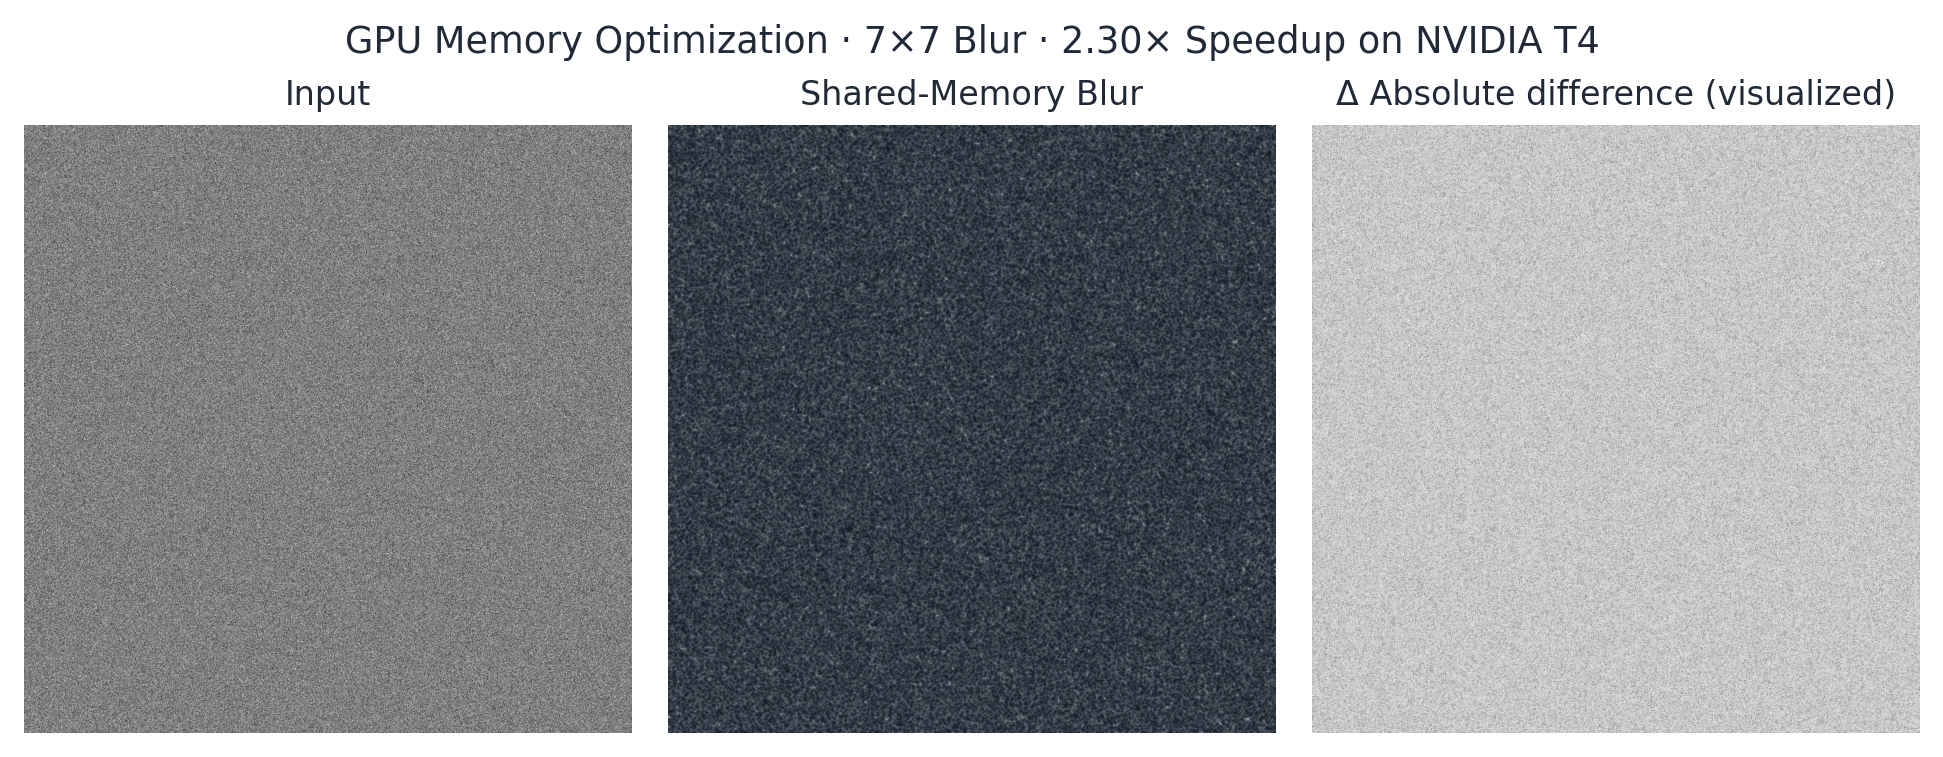

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import re

# ---------- helpers ----------
def read_pgm(path):
    with open(path, "rb") as f:
        assert f.readline().strip() == b"P5"
        line = f.readline()
        while line.startswith(b"#"):
            line = f.readline()
        w, h = map(int, line.split())
        f.readline()  # max value
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((h, w))
    return data

def read_results(path="results.txt"):
    txt = open(path, "r").read()
    def grab(key):
        m = re.search(rf"{key}=(\d+(\.\d+)?)", txt)
        return float(m.group(1)) if m else None
    return grab("naive_ms"), grab("shared_ms"), grab("speedup")

# ---------- load data ----------
inp = read_pgm("input.pgm").astype(np.float32)
blr = read_pgm("blurred.pgm").astype(np.float32)
_, _, speedup = read_results("results.txt")

# ---------- normalize blur brightness (avoid filter-look) ----------
inp_mean, inp_std = inp.mean(), inp.std()
blr = (blr - blr.mean()) / (blr.std() + 1e-6) * inp_std + inp_mean
blr = np.clip(blr, 0, 255)

# ---------- subtle line drawing (gradient contours) ----------
gx = np.zeros_like(blr)
gy = np.zeros_like(blr)
gx[:, 1:-1] = blr[:, 2:] - blr[:, :-2]
gy[1:-1, :] = blr[2:, :] - blr[:-2, :]
edges = np.sqrt(gx**2 + gy**2)
edges = (edges - edges.min()) / (edges.max() - edges.min() + 1e-6)

# ---------- difference visualization ----------
diff = np.abs(inp - blr)

# ---------- styling ----------
c_text = "#1f2937"  # charcoal

plt.figure(figsize=(8.2, 3.2), dpi=240)

# Input
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(inp, cmap="gray", vmin=0, vmax=255)
ax1.set_title("Input", fontsize=10, color=c_text)
ax1.axis("off")

# Shared blur + line drawing
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(blr, cmap="gray", vmin=0, vmax=255)
ax2.contour(edges, levels=6, colors=c_text, linewidths=0.4, alpha=0.45)
ax2.set_title("Shared-Memory Blur", fontsize=10, color=c_text)
ax2.axis("off")

# Absolute difference
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(diff, cmap="Greys")
ax3.set_title("Δ Absolute difference (visualized)", fontsize=10, color=c_text)
ax3.axis("off")

plt.suptitle(
    f"GPU Memory Optimization · 7×7 Blur · {speedup:.2f}× Speedup on NVIDIA T4",
    fontsize=11,
    color=c_text
)

plt.tight_layout()
plt.savefig("linkedin_gpu_blur_final.png", bbox_inches="tight")
plt.show()



In [42]:
!ls -lh


total 24M
-rw-r--r-- 1 root root  4.1M Feb  9 00:53 blurred.pgm
-rwxr-xr-x 1 root root 1005K Feb  9 00:53 blur_shared
-rw-r--r-- 1 root root  7.0K Feb  9 00:53 blur_shared.cu
-rw-r--r-- 1 root root  4.1M Feb  9 00:53 input.pgm
-rw-r--r-- 1 root root  7.1M Feb  9 00:47 linkedin_blur_pastel_lineart.png
-rw-r--r-- 1 root root  1.9M Feb  9 00:57 linkedin_gpu_blur_clean.png
-rw-r--r-- 1 root root  2.1M Feb  9 00:59 linkedin_gpu_blur_final.png
-rw-r--r-- 1 root root  991K Feb  9 00:54 linkedin_gpu_blur_professional.png
-rw-r--r-- 1 root root  2.2M Feb  9 00:49 linkedin_gpu_blur_visual.png
-rw-r--r-- 1 root root    54 Feb  9 00:53 results.txt
drwxr-xr-x 1 root root  4.0K Dec  9 14:42 sample_data
